In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR100
from torchvision import transforms

In [11]:
class CNNCifar100(nn.Module):
    def __init__(self):
        super(CNNCifar100, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
        )

        self.dw_latent = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(4 * 4 * 48, 256),
        )
        
        self.latent = nn.Linear(256, 256)
        
        self.up_latent = nn.Sequential(
            nn.Linear(128, 256),
            nn.Linear(256, 4 * 4 * 48),            
        )

        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

        self.act = nn.Sigmoid()


    def forward(self, x):
        enc = self.encoder(x)
        lat = self.latent(self.dw_latent(enc))
        mu, lv = self.unwrap(lat)
        rec_lat = self.up_latent(self.reparam(mu, lv))
        dec = self.decoder(rec_lat.view(-1, 48, 4, 4))
        
        return x, mu, lv

    def unwrap(self, x):
        return torch.split(x, x.shape[1]//2, dim=1)

    def reparam(self, mu, lv):
        if self.training:
            std = torch.exp(0.5 * lv)
            eps = torch.randn_like(std)
            return mu + std * eps
        else:
            return mu

In [12]:
def gaussian_kls(mu, logvar, mean=False):

    klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())

    if mean:
        reduce = lambda x: torch.mean(x, 1)
    else:
        reduce = lambda x: torch.sum(x, 1)

    total_kld = reduce(klds).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = reduce(klds).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld

In [13]:
def matrix_diag(diagonal):
    N = diagonal.shape[-1]
    shape = diagonal.shape[:-1] + (N, N)
    device, dtype = diagonal.device, diagonal.dtype
    result = torch.zeros(shape, dtype=dtype, device=device)
    indices = torch.arange(result.numel(), device=device).reshape(shape)
    indices = indices.diagonal(dim1=-2, dim2=-1)
    result.view(-1)[indices] = diagonal
    return result

In [14]:
def dip_vae_i_loss(mu, lambda_d, lambda_od):
    exp_mu = mu.mean(0)
    exp_mu_mu_t = (mu.unsqueeze(1) * mu.unsqueeze(2)).mean(0)

    cov = exp_mu_mu_t - exp_mu.unsqueeze(0) * exp_mu.unsqueeze(1)
    diag = torch.diagonal(cov, dim1=-2, dim2=-1)
    off_diag = cov - matrix_diag(diag)

    regulariser_od = lambda_od * (off_diag**2).sum()
    regulariser_d = lambda_d * ((diag-1)**2).sum()

    return regulariser_od + regulariser_d

In [15]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

trainset = CIFAR100(root='~/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=2048, shuffle=True, num_workers=2)
testset = CIFAR100(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=2048, shuffle=False, num_workers=2)

print(len(train_dl), len(test_dl))

Files already downloaded and verified
Files already downloaded and verified
25 5


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNNCifar100().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.0001)

loss_fn = nn.MSELoss()

lmbda_d = 1
lmbda_od = 10

In [17]:
for epoch in range(1):
    model.train()
    tr_total_loss = 0
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss, _, _ = gaussian_kls(train_mu, train_lv)
        train_dip_loss = dip_vae_i_loss(train_mu, lmbda_d, lmbda_od)
        train_loss = train_rec_loss + train_kl_loss + train_dip_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss, _, _ = gaussian_kls(valid_mu, valid_lv)
            valid_dip_loss = dip_vae_i_loss(valid_mu, lmbda_d, lmbda_od)
            valid_loss = valid_rec_loss + valid_kl_loss + valid_dip_loss

            va_total_loss += valid_loss.item()

    print(f"Epoch: {epoch} - TrainLoss: {tr_total_loss/len(train_dl)} - ValidLoss: {va_total_loss/len(test_dl)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]

Epoch: 0 - TrainLoss: 128.01352142333985 - ValidLoss: 127.8945083618164


  0%|                                                                                                                  | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 20%|█████████████████████▏                                                                                    | 2/10 [00:00<00:00, 16.25it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with R

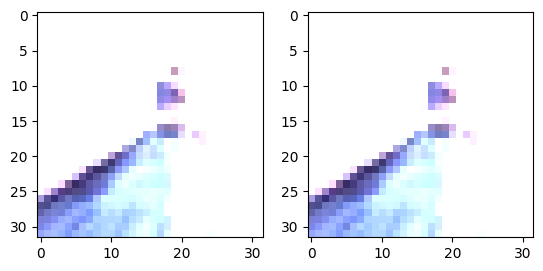

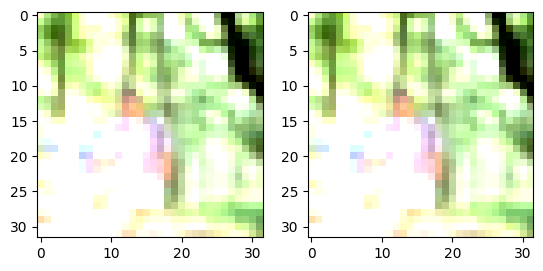

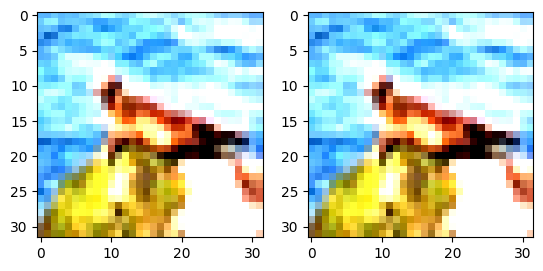

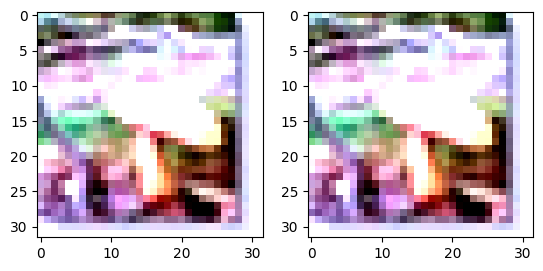

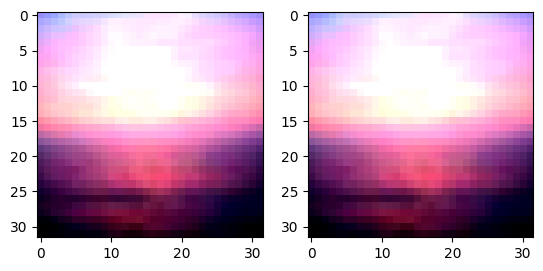

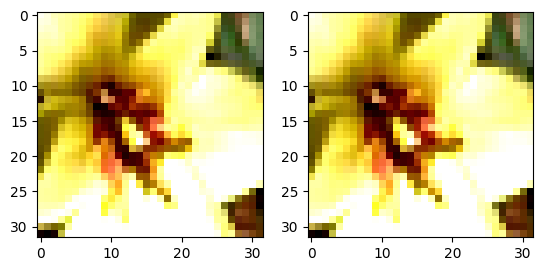

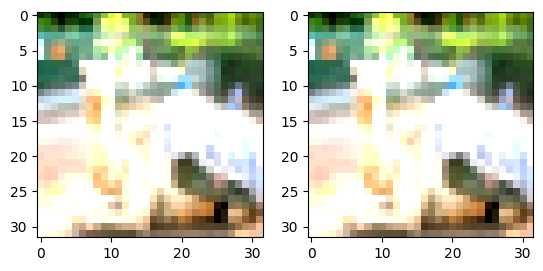

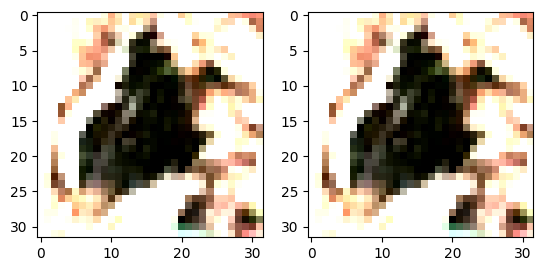

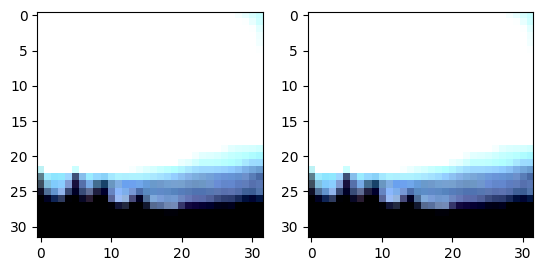

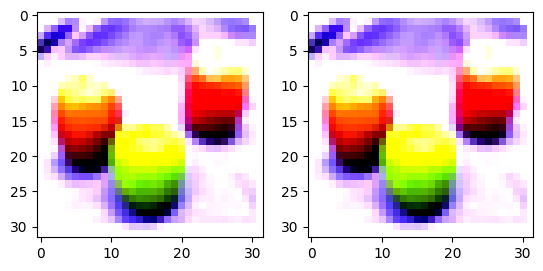

In [18]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = testset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img, _, _ = model(valid_img)        

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())